In [78]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import interpolate


#### Create synthetic residuals that are a function of length along the profile `x`, and time `t`

In [82]:
n_residuals = 20
max_length = 50*1000 # m
max_time = 100 # d
max_off = 100 # m


res = dict()
res['x'] = max_length * np.random.rand(n_residuals) # m
res['t'] = max_time * np.random.rand(n_residuals) # d

noise = np.random.randn(n_residuals) * 5 # m

off_scalar = max_off / (max_length*max_time)
res['off'] = off_scalar * res['x']*res['t'] + noise # create the synthetic residuals, with noise

#### Do the 2-D interpolation:

In [83]:
grid_x, grid_t = np.mgrid[0:max_length:100j, 
                          0:max_time:100j] # create a grid from 0 to max_length and 0 to
                                           #  max_time, with the j number of steps
grid_off = interpolate.griddata((res['x'], res['t']), res['off'], 
                                (grid_x, grid_t), method='cubic')

# tck = interpolate.bisplrep(res['x'], res['t'], res['off'], s=0)
# grid_off = interpolate.bisplev(grid_x[:,0], grid_t[0,:], tck)

# f = interpolate.interp2d(res['x'], res['t'], res['off'], kind='cubic')
# grid_off = f(grid_x[:,0], grid_t[0,:])

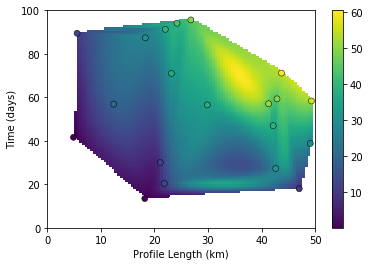

In [84]:
plt.figure()
plt.pcolormesh(grid_x/1000, grid_t, (grid_off))
plt.scatter(res['x']/1000, res['t'], c=res['off'], linewidth=.5, edgecolor='k')
plt.xlabel('Profile Length (km)')
plt.ylabel('Time (days)')
plt.colorbar();
plt.show()